In [1]:
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
#import nms


#posuvne okenko
def sliding_window(image, stepSize,windowSize): 
    for y in range(0, image.shape[0],stepSize):  
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
model_path = 'load_model/modelSVM.npy' #cesta k modelu
image_path = 'img/myImg_11.jpg' #cesta k testovanemu obrazku
out_path= 'test_images/test.jpg' #kam se bude obrazek ukladat

model = joblib.load(model_path) # nacteni modelu
scale = 0
detections = []
img = cv2.imread(image_path)
img_copo=cv2.imread(image_path)
img=rgb2gray(img)



(winW, winH) = (64, 128) # velikost posuvneho okenka
windowSize = (winW, winH)
downscale = 1.5
# Aplikace posuvneho okenka:
for resized in pyramid_gaussian(img, downscale):  #obrazkova pyramida
    for (x, y, window) in sliding_window(resized, stepSize=5, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:  # ensure the sliding window has met the minimum size requirement
            continue

        fds = hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
        fds = fds.reshape(1, -1) 
        pred = model.predict(fds)  # použití SVM klasifikátoru pro predikci

        if pred == 1:
            if model.decision_function(fds) > 4: #threshold systému
                print("Detection(x,y) -> ({}, {})".format(x, y))
                print("Scale ->  {} | conf. score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),int(windowSize[0]*(downscale**scale)), int(windowSize[1]*(downscale**scale))))
    scale+=1

clone = resized.copy()

'''
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(img_copo, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 255, 0), thickness = 2)
'''
sc = [score[0] for (x, y, score, w, h) in detections]
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) #nms
print("detection confidence score: ", sc)

sc = np.array(sc)
pick = non_max_suppression(rects, probs=sc, overlapThresh = 0.3)
#c=0
for (xA, yA, xB, yB) in pick:
    #cv2.rectangle(img_copo, (xA, yA), (xB, yB), (0, 255, 0), 2)
    cv2.rectangle(img_copo, (xA, yA), (xB, yB), (0, 0, 255), 2)

    #middlex(c)=xA-xB
    #middleb(c)=yA-yB


cv2.imwrite(out_path, img_copo)

cv2.destroyAllWindows()



Detection(x,y) -> (225, 145)
Scale ->  0 | conf. score [4.38186987] 

detection confidence score:  [4.38186987066696]


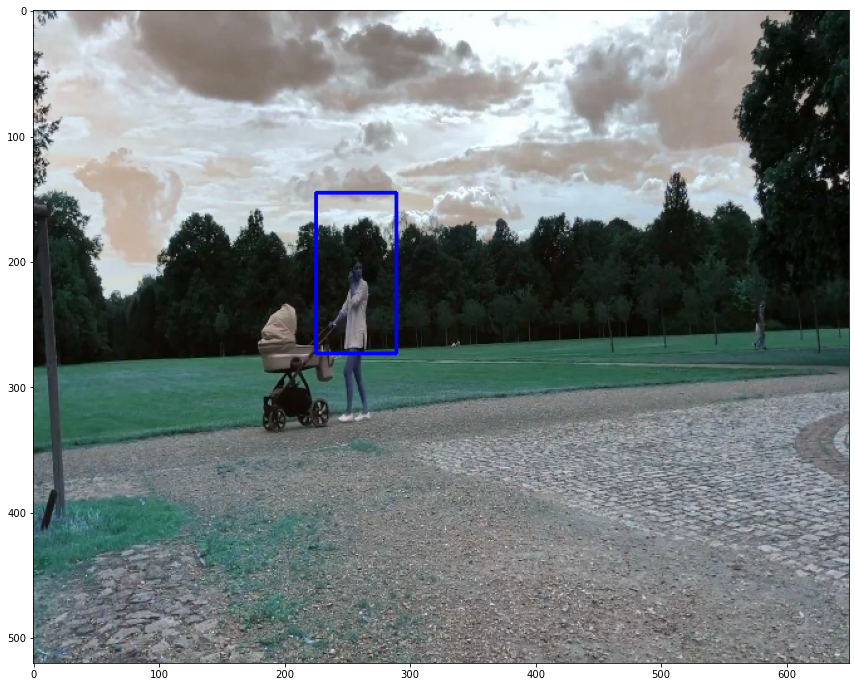

In [2]:
plt.figure(figsize=(20,12))
plt.imshow(img_copo)